In [ ]:
import csv
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/cs3244/

Mounted at /content/drive
/content/drive/MyDrive/cs3244


In [ ]:
# Read the data and drop irrelevant columns
df = pd.read_csv('Guns incident Data.csv')
df.drop('S.No.', axis=1, inplace=True)
df.drop('Year', axis=1, inplace=True)
df.drop('Month', axis=1, inplace=True)
df.drop('Date', axis=1, inplace=True)
df.drop('Hispanic', axis=1, inplace=True)
#df.drop('Place of incident', axis=1, inplace=True)
#df.drop('Police involvement', axis=1, inplace=True)
df.dropna(inplace=True) # drop rows with nan values
df.head()

,Reason,Education,Sex,Age,Race,Place of incident,Police involvement
0,Suicide,Bachelors,Male,35.0,Asian/Pacific Islander,Home,0
1,Suicide,Some college,Female,22.0,White,Street,0
2,Suicide,Bachelors,Male,61.0,White,Other specified,0
3,Suicide,Bachelors,Male,65.0,White,Home,0
4,Suicide,High School,Male,32.0,White,Other specified,0


In [ ]:
print(df.shape)

(98015, 7)


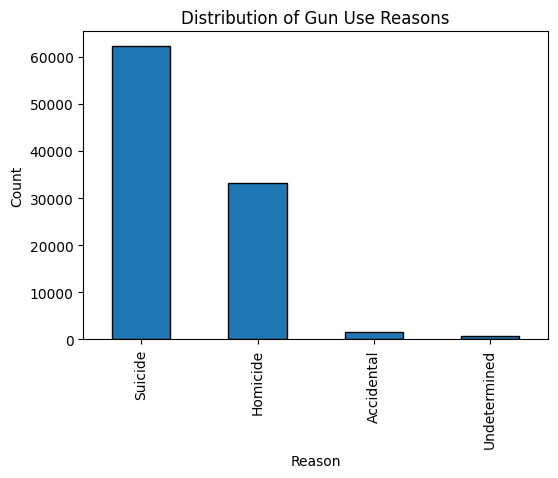

<Figure size 800x500 with 0 Axes>

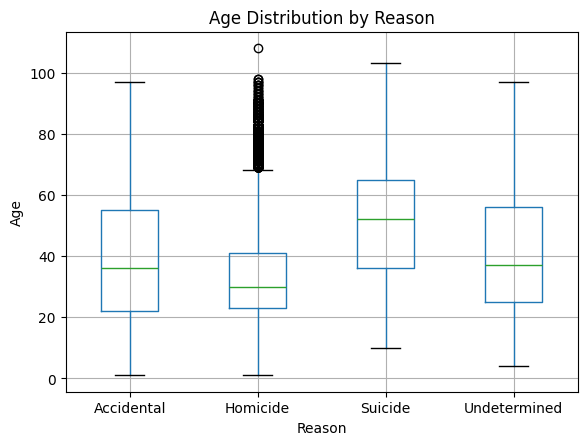

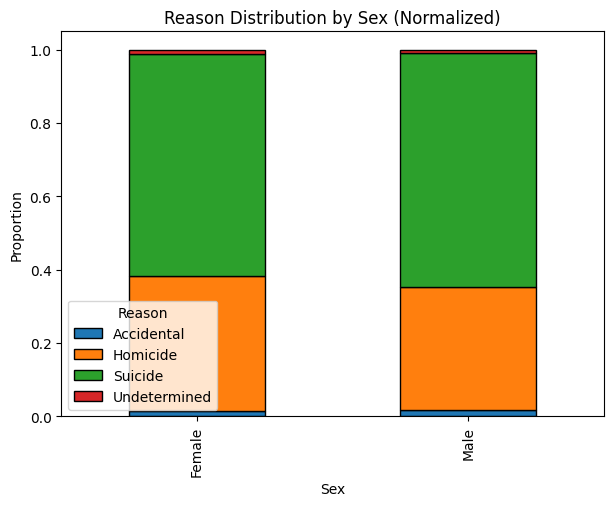

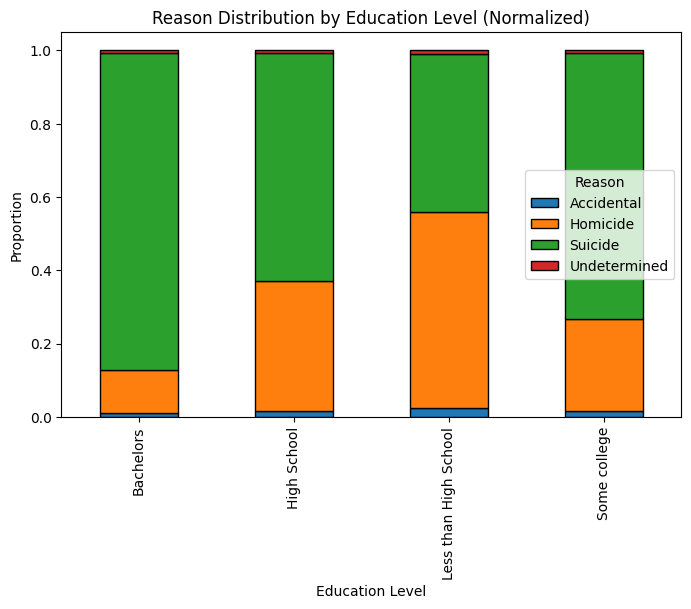

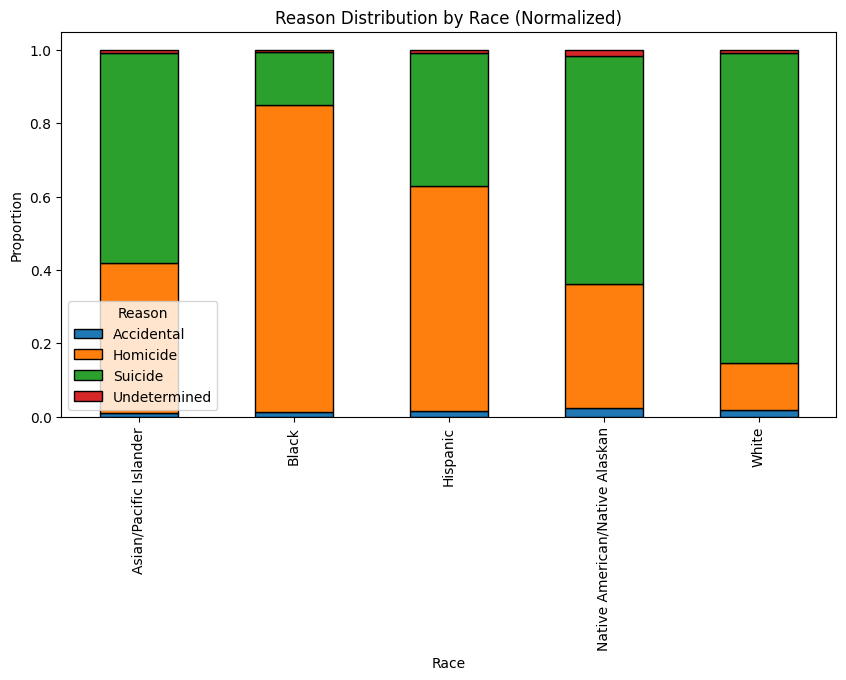

In [ ]:
plt.figure(figsize=(6,4))
df['Reason'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Distribution of Gun Use Reasons')
plt.xlabel('Reason')
plt.ylabel('Count')
plt.show()
# From the distribution of Gun Use Reasons, most are suicide (60000), followed by Homicide (35000),
# while accidental and undetermined have low counts.

plt.figure(figsize=(8,5))
df.boxplot(column='Age', by='Reason')
plt.title('Age Distribution by Reason')
plt.suptitle("")  # Remove automatic title
plt.ylabel('Age')
plt.show()
# From the boxplot of age distribution by reason, older people tend to suicide, and younger people tend to homicide.

crosstab_sex = pd.crosstab(df['Sex'], df['Reason'], normalize='index')
crosstab_sex.plot(kind='bar', stacked=True, figsize=(7,5), edgecolor='black')
plt.title('Reason Distribution by Sex (Normalized)')
plt.xlabel('Sex')
plt.ylabel('Proportion')
plt.legend(title='Reason')
plt.show()

crosstab_edu = pd.crosstab(df['Education'], df['Reason'], normalize='index')
crosstab_edu.plot(kind='bar', stacked=True, figsize=(8,5), edgecolor='black')
plt.title('Reason Distribution by Education Level (Normalized)')
plt.xlabel('Education Level')
plt.ylabel('Proportion')
plt.legend(title='Reason')
plt.show()
# From the bar graph of reason distribution by education level, people with less than high school tend to homicide,
# people with bachelors tend to suicide.

crosstab_race = pd.crosstab(df['Race'], df['Reason'], normalize='index')
crosstab_race.plot(kind='bar', stacked=True, figsize=(10,5), edgecolor='black')
plt.title('Reason Distribution by Race (Normalized)')
plt.xlabel('Race')
plt.ylabel('Proportion')
plt.legend(title='Reason')
plt.show()
# From the bar graph of reason distrubution by race, black people tend to homicide, while white people tend to suicide.


In [ ]:
# Step 1. Define the prediction target (binary outcome), grouping Accidental and Undetermined together
df['Is_Suicide'] = df['Reason'].apply(lambda x: 1 if x == 'Suicide' else 0)

df['Is_Homicide'] = df['Reason'].apply(lambda x: 1 if x == 'Homicide' else 0)

df['Is_Others'] = df['Reason'].apply(lambda x: 1 if x != 'Homicide' and x != 'Suicide' else 0)

print(df.shape)
df.head()


(98015, 10)


,Reason,Education,Sex,Age,Race,Place of incident,Police involvement,Is_Suicide,Is_Homicide,Is_Others
0,Suicide,Bachelors,Male,35.0,Asian/Pacific Islander,Home,0,1,0,0
1,Suicide,Some college,Female,22.0,White,Street,0,1,0,0
2,Suicide,Bachelors,Male,61.0,White,Other specified,0,1,0,0
3,Suicide,Bachelors,Male,65.0,White,Home,0,1,0,0
4,Suicide,High School,Male,32.0,White,Other specified,0,1,0,0


In [ ]:
# -----------------------------
# Step 0: Prepare features and targets
# -----------------------------
X = pd.get_dummies(df[['Age', 'Sex', 'Race', 'Education', 'Place of incident', 'Police involvement']], drop_first=True)
y_suicide = df['Is_Suicide']
y_homicide = df['Is_Homicide']
y_others = df['Is_Others']

# -----------------------------
# Step 1: Split data ONCE
# -----------------------------
X_train, X_test, y_suicide_train, y_suicide_test, y_homicide_train, y_homicide_test, y_others_train, y_others_test = train_test_split(
    X, y_suicide, y_homicide, y_others,
    test_size=0.2, random_state=42
)


# -----------------------------
# Step 2: Apply SMOTE to training data separately
# -----------------------------
smote = SMOTE(random_state=42)

X_train_suicide, y_train_suicide_res = smote.fit_resample(X_train, y_suicide_train)
X_train_homicide, y_train_homicide_res = smote.fit_resample(X_train, y_homicide_train)
X_train_others, y_train_others_res = smote.fit_resample(X_train, y_others_train)

# -----------------------------
# Step 3: Train logistic regression models (One-Vs-All)
# -----------------------------
model_suicide = LogisticRegression(max_iter=1000)
model_suicide.fit(X_train_suicide, y_train_suicide_res)
prob_suicide = model_suicide.predict_proba(X_test)[:, 1]
print(prob_suicide)

model_homicide = LogisticRegression(max_iter=1000)
model_homicide.fit(X_train_homicide, y_train_homicide_res)
prob_homicide = model_homicide.predict_proba(X_test)[:, 1]
print(prob_homicide)

model_others = LogisticRegression(max_iter=1000)
model_others.fit(X_train_others, y_train_others_res)
prob_others = model_others.predict_proba(X_test)[:, 1]
print(prob_others)

y_pred = []

for x, y, z in zip(prob_suicide, prob_homicide, prob_others):
    max_prob = max(x, y, z)
    if max_prob == x:
        y_pred.append('Suicide')
    elif max_prob == y:
        y_pred.append('Homicide')
    else:
        y_pred.append('Others')

print(y_pred)

[0.6864619  0.79677479 0.95053419 ... 0.95738399 0.89473664 0.26086405]
[0.29265282 0.18704665 0.04209221 ... 0.03483847 0.09084214 0.75240143]
[0.68468449 0.58323856 0.32891453 ... 0.13535008 0.47550071 0.25459411]
['Suicide', 'Suicide', 'Suicide', 'Homicide', 'Homicide', 'Suicide', 'Homicide', 'Suicide', 'Suicide', 'Suicide', 'Homicide', 'Suicide', 'Suicide', 'Suicide', 'Suicide', 'Homicide', 'Suicide', 'Suicide', 'Suicide', 'Homicide', 'Suicide', 'Homicide', 'Suicide', 'Homicide', 'Suicide', 'Homicide', 'Suicide', 'Suicide', 'Suicide', 'Homicide', 'Others', 'Suicide', 'Homicide', 'Suicide', 'Suicide', 'Homicide', 'Homicide', 'Suicide', 'Homicide', 'Suicide', 'Suicide', 'Homicide', 'Suicide', 'Suicide', 'Homicide', 'Homicide', 'Homicide', 'Homicide', 'Homicide', 'Suicide', 'Homicide', 'Homicide', 'Suicide', 'Suicide', 'Homicide', 'Homicide', 'Suicide', 'Suicide', 'Homicide', 'Homicide', 'Homicide', 'Others', 'Suicide', 'Suicide', 'Suicide', 'Suicide', 'Suicide', 'Suicide', 'Suicide',

In [ ]:
y_test = []

for x, y, z in zip(y_suicide_test, y_homicide_test, y_others_test):
    label = max(x, y, z)
    if label == x:
        y_test.append('Suicide')
    elif label == y:
        y_test.append('Homicide')
    else:
        y_test.append('Others')


print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7821761975207876

Classification Report:
               precision    recall  f1-score   support

    Homicide       0.76      0.78      0.77      6656
      Others       0.05      0.14      0.08       474
     Suicide       0.87      0.81      0.84     12473

    accuracy                           0.78     19603
   macro avg       0.56      0.57      0.56     19603
weighted avg       0.81      0.78      0.80     19603



In [ ]:
# -----------------------------
# Step 4: Predict and evaluate on the SAME test set
# -----------------------------
def evaluate_model(model, y_test, X_test, model_name):
    y_pred = model.predict(X_test)
    print(f"=== {model_name} Model ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("-"*50)
    return y_pred

y_pred_suicide = evaluate_model(model_suicide, y_suicide_test, X_test, "Suicide")
y_pred_homicide = evaluate_model(model_homicide, y_homicide_test, X_test, "Homicide")
y_pred_others = evaluate_model(model_others, y_others_test, X_test, "Others")

# -----------------------------
# Step 5: Optional - Feature importance
# -----------------------------
def print_coefficients(model, X, model_name):
    coeffs = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_[0]
    }).sort_values(by='Coefficient', ascending=False)
    print(f"=== Feature Importance: {model_name} ===")
    print(coeffs)
    print("-"*50)

print_coefficients(model_suicide, X, "Suicide")
print_coefficients(model_homicide, X, "Homicide")
print_coefficients(model_others, X, "Others")

=== Suicide Model ===
Accuracy: 0.8307401928276285

Confusion Matrix:
 [[ 5419  1711]
 [ 1607 10866]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.77      7130
           1       0.86      0.87      0.87     12473

    accuracy                           0.83     19603
   macro avg       0.82      0.82      0.82     19603
weighted avg       0.83      0.83      0.83     19603

--------------------------------------------------
=== Homicide Model ===
Accuracy: 0.8392592970463705

Confusion Matrix:
 [[11262  1685]
 [ 1466  5190]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88     12947
           1       0.75      0.78      0.77      6656

    accuracy                           0.84     19603
   macro avg       0.82      0.82      0.82     19603
weighted avg       0.84      0.84      0.84     19603

----------------------------------------